Import data

In [6]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import os
import json
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
from numpy import array
from numpy import asarray
from skimage.filters import try_all_threshold
from skimage.filters import threshold_local
from skimage.feature import canny
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.segmentation import slic
from skimage.measure import find_contours
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import corner_harris
from skimage.feature import corner_peaks



# Get database connection credentials
with open(os.path.join(os.getcwd(),'fb_marketplace_conn.json'), mode='r') as f:
    database_dict = json.load(f)
# Password for the database
RDS_pass = 'aicore2022!'
# Create engine to connect to database
engine = create_engine(f"{database_dict['DATABASE_TYPE']}+{database_dict['DBAPI']}://{database_dict['USER']}:{RDS_pass}@{database_dict['HOST']}:{database_dict['PORT']}/{database_dict['DATABASE']}")
# Import the tables as DataFrame
images = pd.read_sql('images', engine)



Profile data

In [ ]:
prof = ProfileReport(images)
prof.to_file(output_file='images.html')

Image cleansing functions

In [3]:
# https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
def show(image: np.ndarray, title="Image", cmap_type="gray", axis=False):
    """
    A function to display np.ndarrays as images
    """
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    if not axis:
        plt.axis("off")
    plt.margins(0, 0)
    plt.show()

def mark_contours(image):
    """A function to find contours from an image"""
    gray_image = rgb2gray(image)
    # Find optimal threshold
    thresh = threshold_otsu(gray_image)
    # Mask
    binary_image = gray_image > thresh

    contours = find_contours(binary_image)

    return contours
    
def plot_image_contours(image):
    fig, ax = plt.subplots()

    ax.imshow(image, cmap=plt.cm.gray)

    for contour in mark_contours(image):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="red")

    ax.axis("off")

def plot_with_hist_channel(image, channel):
    """
    Histogram of color channels
    """
    channels = ["red", "green", "blue"]
    channel_idx = channels.index(channel)
    color = channels[channel_idx]
    extracted_channel = image[:, :, channel_idx]
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(18, 6)
    )
    ax1.imshow(image)
    ax1.axis("off")
    ax2.hist(extracted_channel.ravel(), bins=256, color=color)
    ax2.set_title(f"{channels[channel_idx]} histogram")

def resize_image(image: Image, length: int) -> Image:
    """
    Resize an image to a square. Can make an image bigger to make it fit or smaller if it doesn't fit. It also crops
    part of the image.
    https://stackoverflow.com/questions/43512615/reshaping-rectangular-image-to-square

    :param self:
    :param image: Image to resize.
    :param length: Width and height of the output image.
    :return: Return the resized image.
    """

    """
    Resizing strategy : 
     1) We resize the smallest side to the desired dimension (e.g. 1080)
     2) We crop the other side so as to make it fit with the same length as the smallest side (e.g. 1080)
    """
    if image.size[0] < image.size[1]:
        # The image is in portrait mode. Height is bigger than width.

        # This makes the width fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))

        # Amount of pixel to lose in total on the height of the image.
        required_loss = (resized_image.size[1] - length)

        # Crop the height of the image so as to keep the center part.
        resized_image = resized_image.crop(
            box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))

        # We now have a length*length pixels image.
        return resized_image
    else:
        # This image is in landscape mode or already squared. The width is bigger than the heihgt.

        # This makes the height fit the LENGTH in pixels while conserving the ration.
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))

        # Amount of pixel to lose in total on the width of the image.
        required_loss = resized_image.size[0] - length

        # Crop the width of the image so as to keep 1080 pixels of the center part.
        resized_image = resized_image.crop(
            box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))

        # We now have a length*length pixels image.
        return resized_image
    

        
    def compare(original, filtered, title_filtered="Filtered", cmap_type="gray", axis=False, title_original="Original"):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)
        ax1.imshow(original, cmap=cmap_type)
        ax1.set_title(title_original)

        ax2.imshow(filtered, cmap=cmap_type)
        ax2.set_title(title_filtered)

        if not axis:
            ax1.axis("off")
            ax2.axis("off")
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0.01)
        plt.margins(0, 0)
        plt.show()


Image playground

In [ ]:

image_path = os.path.join(os.getcwd(),'images_fb/images/','0a1d0925-d2aa-4e89-b9d3-ef56b834cfd9.jpg')
img = Image.open(image_path)
# Image name
img_filename = img.filename
# Image format e.g. JPRG
img_format = img.format
# Image mode e.g. RGB
img_mode = img.mode
# Image size as tupe (width, height)
img_size = img.size
# Image info - a dictionary wiht image info
img_info = img.info
print(img_info)
# Convert to numpy array
img2arr = array(img)
print(img2arr)

Planned for data preparation
Notes for consideration for later:
- Image data should probably be centered by subtracting the per-channel mean pixel values calculated on the training dataset.
- Training data augmentation should probably involve random rescaling, horizontal flips, perturbations to brightness, contrast and color, as well as random cropping.
- Test-time augmentation should probably involve both a mixture of multiple rescaling of each image as well as predictions for multiple different systematic crops of each rescaled version of the image.

https://towardsdatascience.com/massive-tutorial-on-image-processing-and-preparation-for-deep-learning-in-python-1-e534ee42f122
https://machinelearningmastery.com/start-here/#dlfcv - nice overall guide to managing images
https://machinelearningmastery.com/deep-learning-for-computer-vision/ - a book for computer vision
https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/ - sing pillow
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

pixel mean is 105.69892883300781
Min: 1.000, Max: 245.000
image_contrast is 244


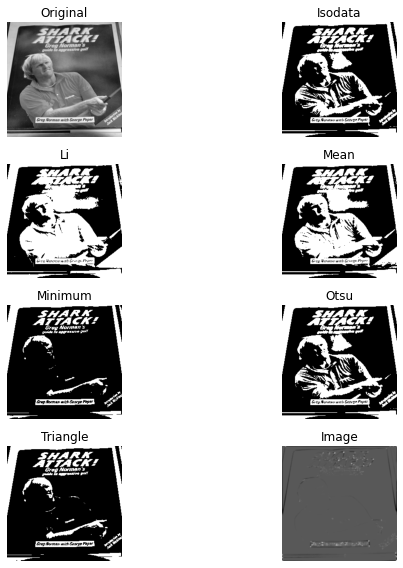

1
pixel mean is 73.18865966796875
Min: 3.000, Max: 255.000
image_contrast is 252


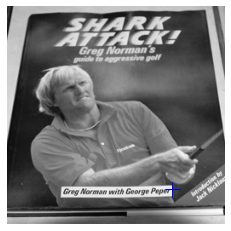

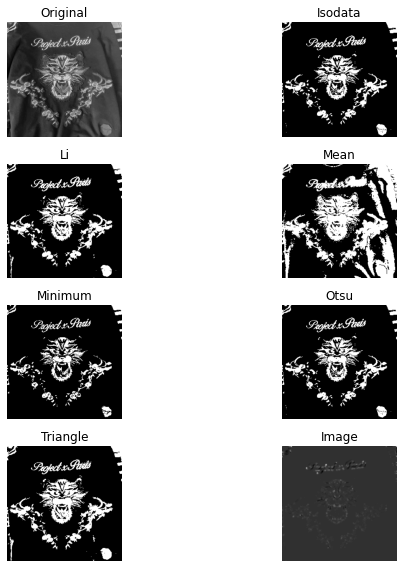

4
pixel mean is 183.8766632080078
Min: 6.000, Max: 254.000
image_contrast is 248


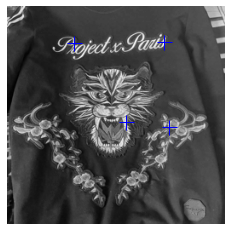

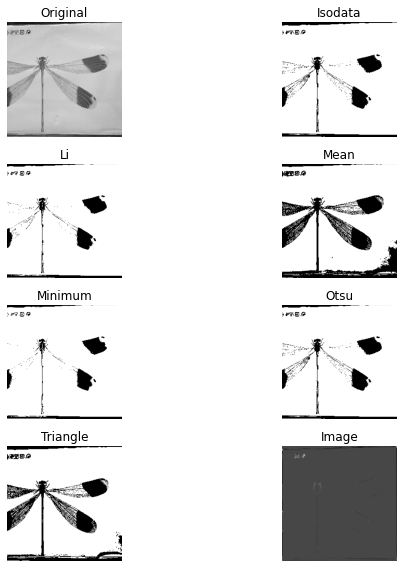

6
pixel mean is 82.87905883789062
Min: 3.000, Max: 253.000
image_contrast is 250


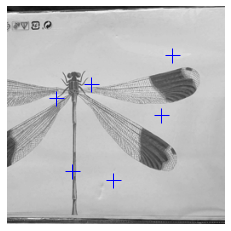

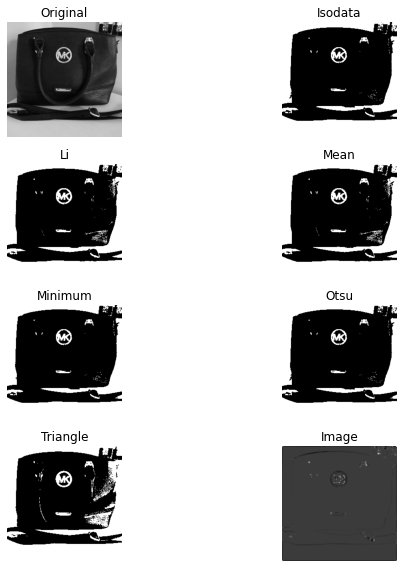

3
pixel mean is 104.0478515625
Min: 28.000, Max: 255.000
image_contrast is 227


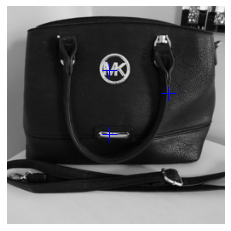

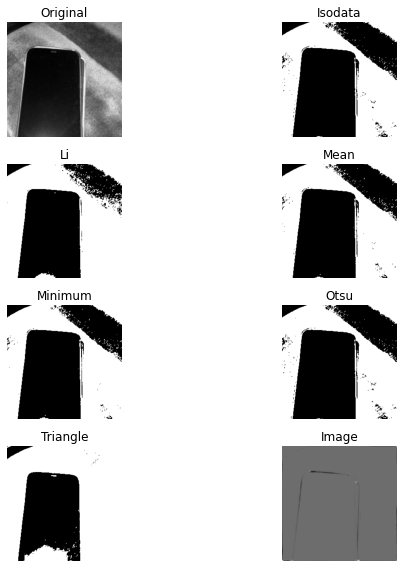

2


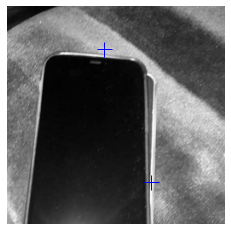

In [19]:
# Get all images file names  - for now play with first 100
# example of global centering (subtract mean)


download_image_directory = os.path.join(os.getcwd(),'images_fb/test_images/')
upload_image_directory = os.path.join(os.getcwd(),'images_fb/cleaned_test_images/')
img_list = []
for file in os.listdir(download_image_directory):
        # get image
        img =Image.open(os.path.join(download_image_directory,file))
        if img.height == img.width:
            # square images to 256 x 256
            img.resize(256,256)
        else:
            # rectangle images to 256 on shortest size then the middle 256 x 256 sqaure crop
            img = resize_image(img, 256)
        colour_img = img
        colour_img_array = np.asarray(colour_img)
        # Consider converting to greyscale
        img = img.convert(mode='L')
        # Normalise the data - scaling pixel values to the range 0-1
        img_array = asarray(img)
        pixels = img_array.astype('float32')
        pixel_mean = pixels.mean()
        print(f'pixel mean is {pixel_mean}')
        print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
        normalise_array = pixels
        normalise_array /= 255
        # Consider thresholding to get better image definition - consider a check whther threshold or type of threshold to use per image
        # Manual Global threshold
        threshold = normalise_array.mean()
        binary_array = normalise_array > threshold
        binary_image = Image.fromarray(binary_array)
        # Review algorithm based global threshold - looks like mean was best across them but different images are goign to benefit in different ways
        fig, ax = try_all_threshold(img_array, figsize=(10, 8), verbose=False)
        # Local threshold algorithims
        local_thresh = threshold_local(img_array, block_size=5, offset=2.000)
        local_binary = img_array > local_thresh
        local_binary_img = Image.fromarray(local_binary)
        # local_binary_img.show()
        # Edge detection
        product_edge = canny(img_array, sigma=1)
        product_edge = Image.fromarray(product_edge)
        product_edge.show()

        # image contrast enhancement - NOT WORKING
        img_contrast = img_array.max() - img_array.min()
        print(f'image_contrast is {img_contrast}')
        enhanced = equalize_adapthist(img_array, clip_limit=0.4)
        enhanced = Image.fromarray(enhanced)


        # image segmentation - NOT WORKING
        segments = slic(colour_img_array, n_segments=100)
        segments = Image.fromarray(segments, mode='L')


        # image contours

        denoise_colour_array = denoise_tv_chambolle(colour_img_array, channel_axis=True)
        print(denoise_colour_array)
        # plot_image_contours(denoise_colour_array)
        # plot_image_contours(colour_img_array)

        # corner detection
        measured_img = corner_harris(img_array)
        show(measured_img)
        denoise_gray_array = denoise_tv_chambolle(img_array, channel_axis=True, weight=0.3)
        corner_coords = corner_peaks(denoise_gray_array, min_distance=40)
        print(len(corner_coords))
        plt.imshow(img_array, cmap="gray")
        plt.plot(corner_coords[:, 1], corner_coords[:, 0], "+b", markersize=15)
        plt.axis("off")
        




        # could have different version of the image and use the oerall score ?

        # Consider a function that allows user to pick whther to centre pre or post normalisation with normalised yes/no
        # Centre prior to normalisation 
        global_centered = pixels
        global_centered = global_centered - pixel_mean
        global_centered = global_centered.mean()




        # Centre post normalisation

        # plt.hist(img_array.ravel(), bins=256)
        # plt.show()

        # build list of  cleaned images
        # img_list.append(img)

        # save the cleaned images
        # check does this replace
        # img.save(os.path.join(upload_image_directory,file), format='JPEG')
        # binary_image.save(os.path.join(upload_image_directory,'binary_'+file), format='JPEG')
# print(img_list)


# img_array_list = asarray(img_list)
# print(img_array_list)

# img_array_list = [array(Image.open(file)) for file in os.listdir(image_directory)]
# print(img_array_list)






# https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

# center pixel values both globally across channels and locally per channel
# standardize pixel values and how to shift standardized pixel values to the positive domain.
# Consider data augmentation - i.e. changign data structure like rotaing etc. to give the model more to train